In [1]:
# line plot of corr(pred rating, true rating) across hold out percentages for subsampled data 
# run on full model, ratings-only model, and reports-only model 
# with semi-synthetic data for types with observed ratings
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
plt.rcParams['font.family'] = 'serif'

# Set the font used for math expressions to LaTeX
plt.rcParams["mathtext.fontset"] = "cm"

In [ ]:
# file paths
base_file = '/share/garg/311_data/sb2377/clean_codebase/three_year_base.csv'
type_rating_observed_base_file = '/share/garg/311_data/sb2377/clean_codebase/three_year_type_rating_observed_base.csv'
results_dir = '/share/garg/311_data/sb2377/results'

# user specified arguments
types = {'Street': 'StreetConditionDOT',
         'Park': 'MaintenanceorFacilityDPR',
         'Rodent': 'RodentDOHMH',
         'Food': 'FoodDOHMH',
         'DCWP': 'ConsumerComplaintDCWP'}
holdout_pcts = {'100':100,
                '500':500,
                '1k':1000,
                '10k':10000,
                '100k':100000}
models = {'Full model': {'Street':{'100':{'job_ids':[i * 10 + 5200 for i in range(5)]},
                                '500':{'job_ids':[i * 10 + 5202 for i in range(5)]},
                                '1k':{'job_ids':[i * 10 + 5204 for i in range(5)]},
                                '10k':{'job_ids':[i * 10 + 5206 for i in range(5)]},
                                '100k':{'job_ids':[i * 10 + 5208 for i in range(5)]},
                                'full':{'job_ids':[i * 3 + 3200 for i in range(5)]}},
                        'Park':{'100':{'job_ids':[i * 10 + 5500 for i in range(5)]},
                                '500':{'job_ids':[i * 10 + 5502 for i in range(5)]},
                                '1k':{'job_ids':[i * 10 + 5504 for i in range(5)]},
                                '10k':{'job_ids':[i * 10 + 5506 for i in range(5)]},
                                '100k':{'job_ids':[i * 10 + 5508 for i in range(5)]},
                                'full':{'job_ids':[i * 3 + 3200 for i in range(5)]}},
                        'Rodent':{'100':{'job_ids':[i * 10 + 5100 for i in range(5)]},
                                '500':{'job_ids':[i * 10 + 5102 for i in range(5)]},
                                '1k':{'job_ids':[i * 10 + 5104 for i in range(5)]},
                                '10k':{'job_ids':[i * 10 + 5106 for i in range(5)]},
                                '100k':{'job_ids':[i * 10 + 5108 for i in range(5)]},
                                'full':{'job_ids':[i * 3 + 3200 for i in range(5)]}},
                        'Food':{'100':{'job_ids':[i * 10 + 5400 for i in range(5)]},
                                      '500':{'job_ids':[i * 10 + 5402 for i in range(5)]},
                                      '1k':{'job_ids':[i * 10 + 5404 for i in range(5)]},
                                      '10k':{'job_ids':[i * 10 + 5406 for i in range(5)]},
                                      '100k':{'job_ids':[i * 10 + 5408 for i in range(5)]},
                                      'full':{'job_ids':[i * 3 + 3200 for i in range(5)]}},
                        'DCWP':{'100':{'job_ids':[i * 10 + 5300 for i in range(5)]},
                                '500':{'job_ids':[i * 10 + 5302 for i in range(5)]},
                                '1k':{'job_ids':[i * 10 + 5304 for i in range(5)]},
                                '10k':{'job_ids':[i * 10 + 5306 for i in range(5)]},
                                '100k':{'job_ids':[i * 10 + 5308 for i in range(5)]},
                                'full':{'job_ids':[i * 3 + 3200 for i in range(5)]}}},
          'Ratings-only model': {'Street':{'100':{'job_ids':[i * 10 + 5201 for i in range(5)]},
                                           '500':{'job_ids':[i * 10 + 5203 for i in range(5)]},
                                           '1k':{'job_ids':[i * 10 + 5205 for i in range(5)]},
                                           '10k':{'job_ids':[i * 10 + 5207 for i in range(5)]},
                                           '100k':{'job_ids':[i * 10 + 5209 for i in range(5)]},
                                           'full':{'job_ids':[i * 3 + 3202 for i in range(5)]}},
                                'Park':{'100':{'job_ids':[i * 10 + 5501 for i in range(5)]},
                                        '500':{'job_ids':[i * 10 + 5503 for i in range(5)]},
                                        '1k':{'job_ids':[i * 10 + 5505 for i in range(5)]},
                                        '10k':{'job_ids':[i * 10 + 5507 for i in range(5)]},
                                        '100k':{'job_ids':[i * 10 + 5509 for i in range(5)]},
                                        'full':{'job_ids':[i * 3 + 3202 for i in range(5)]}},
                                'Rodent':{'100':{'job_ids':[i * 10 + 5101 for i in range(5)]},
                                          '500':{'job_ids':[i * 10 + 5103 for i in range(5)]},
                                          '1k':{'job_ids':[i * 10 + 5105 for i in range(5)]},
                                          '10k':{'job_ids':[i * 10 + 5107 for i in range(5)]},
                                          '100k':{'job_ids':[i * 10 + 5109 for i in range(5)]},
                                          'full':{'job_ids':[i * 3 + 3202 for i in range(5)]}},
                                'Food':{'100':{'job_ids':[i * 10 + 5401 for i in range(5)]},
                                              '500':{'job_ids':[i * 10 + 5403 for i in range(5)]},
                                              '1k':{'job_ids':[i * 10 + 5405 for i in range(5)]},
                                              '10k':{'job_ids':[i * 10 + 5407 for i in range(5)]},
                                              '100k':{'job_ids':[i * 10 + 5409 for i in range(5)]},
                                              'full':{'job_ids':[i * 3 + 3202 for i in range(5)]}},
                                'DCWP':{'100':{'job_ids':[i * 10 + 5301 for i in range(5)]},
                                        '500':{'job_ids':[i * 10 + 5303 for i in range(5)]},
                                        '1k':{'job_ids':[i * 10 + 5305 for i in range(5)]},
                                        '10k':{'job_ids':[i * 10 + 5307 for i in range(5)]},
                                        '100k':{'job_ids':[i * 10 + 5309 for i in range(5)]}},
                                        'full':{'job_ids':[i * 3 + 3202 for i in range(5)]}}}
epoch = '59'

# plotting parameters
figsize=(4, 5)
save_path = "/home/sb2377/gnn_crowdsourced_model/figures/semisynthetic_ratings_subsampled.png"

In [3]:
# load files
base_df = pd.read_csv(base_file)
type_rating_observed_base_df = pd.read_csv(type_rating_observed_base_file)

In [4]:
# get type indices
# for df with all types
type_df = base_df[['typeagency', 'type_idxs']].drop_duplicates()
indices = {}
for type_name, type_id in types.items():
    idx = type_df[type_df['typeagency'] == type_id]['type_idxs'].iloc[0]
    indices[type_name] = idx

# for df with only types with observed ratings
type_df = type_rating_observed_base_df[['typeagency', 'type_idxs']].drop_duplicates()
type_rating_observed_indices = {}
for type_name, type_id in types.items():
    idx = type_df[type_df['typeagency'] == type_id]['type_idxs'].iloc[0]
    type_rating_observed_indices[type_name] = idx

In [5]:
# get predicted ratings for all jobs
checkpoint_file = '{}/job{}/model-epoch={}.ckpt'
results_file = '{}/job{}/epoch={}_test.pkl'
checkpoint_counters = {}
results_counters = {}
for m in models:
    checkpoint_counters[m] = {}
    results_counters[m] = {}
    for t in types:
        checkpoint_counters[m][t] = 0
        results_counters[m][t] = 0
dfs = {}
for m in models:
    dfs[m] = {}
    for t in types:
        dfs[m][t] = {}
        for hold_out_pct in holdout_pcts:
            dfs[m][t][hold_out_pct] = []

for m in models:
    for t in types:
        for hold_out_pct in holdout_pcts:
            for job_idx in models[m][t][hold_out_pct]['job_ids']:
                if os.path.exists(checkpoint_file.format(results_dir, job_idx, epoch)):
                    checkpoint_counters[m][t] += 1
                if os.path.exists(results_file.format(results_dir, job_idx, epoch)):
                    results_counters[m][t] += 1
                    with open(results_file.format(results_dir, job_idx, epoch), 'rb') as file:
                        pred_rating, true_rating, mask, node_embedding, type_embedding, node_idxs, type_idxs, demographics, pred_pt, true_t = pickle.load(file)
                    
                    df = pd.DataFrame()
                    df['pred_rating'] = pred_rating
                    df['true_rating'] = true_rating
                    df['node_idxs'] = node_idxs
                    df['type_idxs'] = type_idxs
                    df['pred_pt'] = pred_pt
                    df['true_t'] = true_t
                    df['mask'] = mask
                    if m == 'Full model':
                        type_df = df[df['type_idxs'] == indices[t]]
                    else:
                        type_df = df[df['type_idxs'] == type_rating_observed_indices[t]]

                    dfs[m][t][hold_out_pct].append(type_df)

for m in models:
    for t in types:
        print('{} {}: checkpoint files done = {}'.format(m, t, checkpoint_counters[m][t]))
        print('{} {}: results files done = {}'.format(m, t, results_counters[m][t]))

Full model Street: checkpoint files done = 25
Full model Street: results files done = 25
Full model Park: checkpoint files done = 25
Full model Park: results files done = 25
Full model Rodent: checkpoint files done = 25
Full model Rodent: results files done = 25
Full model Food: checkpoint files done = 25
Full model Food: results files done = 25
Full model DCWP: checkpoint files done = 25
Full model DCWP: results files done = 25
Ratings-only model Street: checkpoint files done = 25
Ratings-only model Street: results files done = 25
Ratings-only model Park: checkpoint files done = 25
Ratings-only model Park: results files done = 25
Ratings-only model Rodent: checkpoint files done = 25
Ratings-only model Rodent: results files done = 25
Ratings-only model Food: checkpoint files done = 25
Ratings-only model Food: results files done = 25
Ratings-only model DCWP: checkpoint files done = 25
Ratings-only model DCWP: results files done = 25


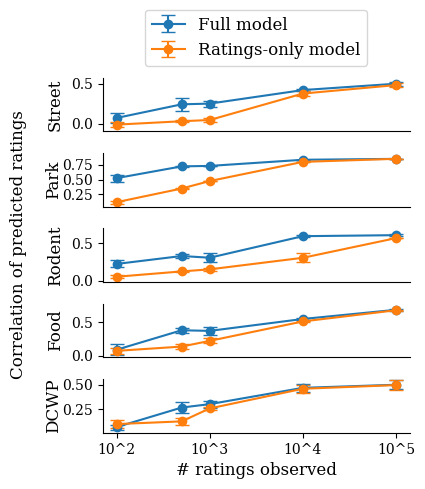

In [8]:
# plot figure
fig, ax = plt.subplots(len(types), 1, figsize=figsize)

# first get correlations for all models, types, and hold out percentages
corrs = {}
for m in models:
    corrs[m] = {}
    for t in types:
        corrs[m][t] = {}
        for hold_out_pct in holdout_pcts:
            corrs[m][t][hold_out_pct] = []
            for observed_df in dfs[m][t][hold_out_pct]:
                # Filter and group the data
                if m == 'Full model':
                    observed_test_type_df = observed_df[observed_df['type_idxs'] == indices[t]]
                else:
                    observed_test_type_df = observed_df[observed_df['type_idxs'] == type_rating_observed_indices[t]]
                node_df = observed_test_type_df.groupby(['node_idxs', 'type_idxs']).mean().reset_index()
                corr = pearsonr(node_df['pred_rating'], node_df['true_rating'])[0]
                corrs[m][t][hold_out_pct].append(corr)

# pre process mean and stderr across hold out percentages for each model x type pair
plot_values = {}
for m in models:
    plot_values[m] = {}
    for t in types:
        corr_set = np.array([corrs[m][t][hold_out_pct] for hold_out_pct in holdout_pcts])
        corr_set_mean = np.nanmean(corr_set, axis=1)
        corr_set_stderr = 1.96 * np.nanstd(corr_set, axis=1) / (np.count_nonzero(~np.isnan(corr_set), axis=1) - 1)
        plot_values[m][t] = {'mean': corr_set_mean, 'stderr': corr_set_stderr}

# make line plot
for i, m in enumerate(models):
    for j, t in enumerate(types):
        ax[j].errorbar(np.log10(np.array(list((holdout_pcts.values())))), np.array(plot_values[m][t]['mean']), yerr=plot_values[m][t]['stderr'], fmt='-o', capsize=5, color='C{}'.format(i), label=m)
        ax[j].set_ylim([min(plot_values['Ratings-only model'][t]['mean'] - plot_values['Ratings-only model'][t]['stderr']) - 0.05, 
                        max(plot_values['Full model'][t]['mean'] - plot_values['Full model'][t]['stderr']) + 0.1])  # Adjust margins
        if j < len(types) - 1:
            ax[j].set_xticklabels([])
            ax[j].set_xticks([])
        else:
            ax[j].set_xticks([2, 3, 4, 5], ['10^2', '10^3', '10^4', '10^5'])
            
        if j in [0, 2, 3]:
            labelpad = 5
        else:
            labelpad = 0
        ax[j].set_ylabel(t, fontsize=12, labelpad=labelpad)
    
sns.despine()

ax[4].set_xlabel('# ratings observed', fontsize=12)
fig.text(-0.05, 0.5, 'Correlation of predicted ratings', va='center', rotation='vertical', fontsize=12)
ax[0].legend(fontsize=12, loc='lower center', bbox_to_anchor=(0.5, 1.07))

# Show plot
plt.tight_layout()
plt.savefig(save_path, dpi=1200, bbox_inches="tight")

In [11]:
for m in plot_values.keys():
    model_corrs = []
    for t in plot_values[m].keys():
        model_corrs.extend(plot_values[m][t]['mean'].tolist())
    model_corrs = np.array(model_corrs)
    print(m, model_corrs.mean(axis=0))

Full model 0.43563173564430224
Ratings-only model 0.31101988800913777
